# Flood Detection Using Landsat 8 Satellite Imagery

Author: **Marcin Sikorski**<br>
Date: January, 2025

**Introduction**<br>
Flooding poses risks to the safety of local inhabitants, and damages infrastructures and lifelines. It is important to accommodate cities and local agencies with enhanced rapid flood detection skills and tools to better understand how much flooding a region may experience at a certain period of time. Satellite imagery has transformed the way we approach flood damage assessment. These images, captured from space, provide a unique and invaluable perspective on the extent of flooding, which is often impossible to obtain through ground surveys alone. Detecting flooding in affected areas help us prioritize response efforts, prepare a management system, and estimate post-flood damages. This notebook demonstrates an easy approach for detecting flooded areas based on Landsat 8 imagery.

**Study Area**<br>
The area of study is the Bombetoka Bay on the northwestern coast of Madagascar near the cities Mahajanga and Boanamary, where the Betsiboka River flows into the Mozambique Channel. The bay has visible sediment transport and suspension. As a result, numerous islands and sandbars have formed in the estuary and have been shaped by the flow of the river and the push and pull of tides. 

**Notebook Content:**
1. Loading and Viewing Imagery Before Flooding
2. Loading and Viewing Imagery During Flooding
3. Calculate Change and Map Flooding
4. Conclusions

### 1. Loading and Viewing Imagery Before Flooding

The first GeoTIFF file to import is an aerial image captured upon the Bombetoka Bay in January 2017. We will load it, explore its data content, and generate some visuals.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import earthpy.plot as ep
import earthpy.spatial as es

In [2]:
from glob import glob
from pprint import pprint

# extract TIFF files and stack into one array
img_before_path = glob(
    'madagascar_before/2017-01-18-00_00_2017-01-18-23_59_Landsat_8_*B*.tiff'
)
img_before_path.sort()
arr_before, meta = es.stack(img_before_path, nodata=-9999)

print('Image shape:', arr_before.shape)
print('Landsat 8 image metadata:')
pprint(meta, indent=2)

Image shape: (9, 602, 676)
Landsat 8 image metadata:
{ 'blockysize': 8,
  'compress': 'deflate',
  'count': 9,
  'crs': CRS.from_epsg(4326),
  'driver': 'GTiff',
  'dtype': 'uint16',
  'height': 602,
  'interleave': 'band',
  'nodata': None,
  'tiled': False,
  'transform': Affine(0.0005393624260355052, 0.0, 46.933594,
       0.0, -0.0005197591362126263, -15.278872),
  'width': 676}


Now, we will plot the file's bands and a natural color composite.

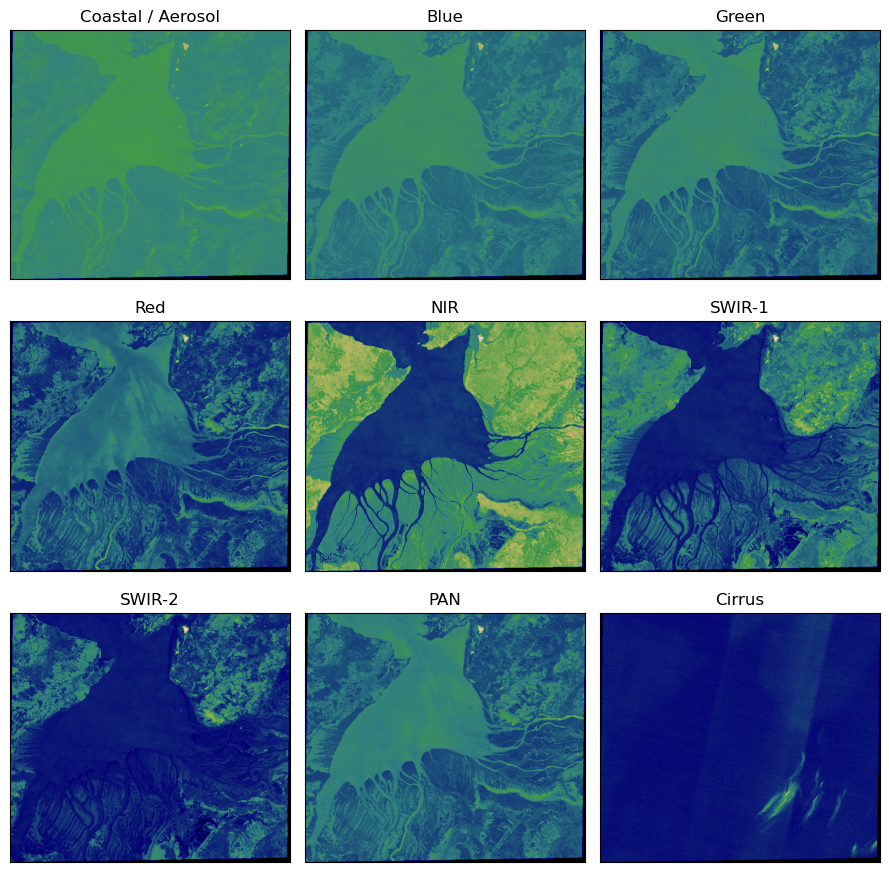

In [3]:
# plot each band
# Band 1: Coastal Aerosol
# Band 2: Blue
# Band 3: Green
# Band 4: Red
# Band 5: Near-Infrared (NIR)
# Band 6: SWIR-1
# Band 7: SWIR-2
# Band 8: Panchromatic (PAN)
# Band 9; Cirrus

titles = [
    'Coastal / Aerosol', 'Blue', 'Green', 'Red', 'NIR',
    'SWIR-1', 'SWIR-2', 'PAN', 'Cirrus'
]

ep.plot_bands(arr_before, cmap='gist_earth', cols=3, cbar=False, title=titles, figsize=(9, 9))
plt.show()

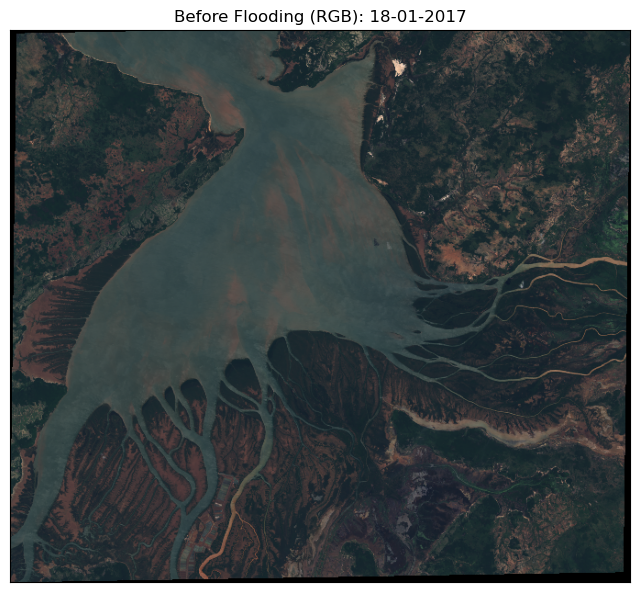

In [4]:
# plot true color composite (red, green, blue)
ep.plot_rgb(arr_before, rgb=(3, 2, 1), figsize=(8, 8), title='Before Flooding (RGB): 18-01-2017')
plt.show()

The Normalized Difference Water Index (NDWI) is a simple indicator in remote sensing that can be used to detect liquid water, sharpen its outline on the map, or to monitor changes related to water content in water bodies. This calculation uses two bands of a Landsat 8 multispectral image dataset, NIR and SWIR bands:

$$\text{NWDI} = \frac{\text{NIR} - \text{SWIR}}{\text{NIR} + \text{SWIR}}.$$

The NDWI value lies between -1 to 1. Values between -1 and 0 indicate no vegetation or water content. Generally, water bodies NDWI value is greater than 0.6. Vegetation has much smaller values. Build-up features or non-aqueous surfaces have positive values lying between 0 to 0.3.

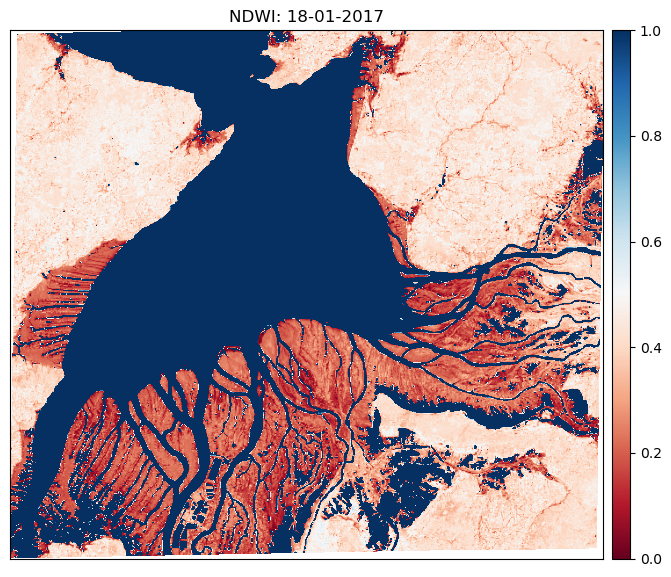

In [5]:
# function to normalize bands and calculate the math (b1 - b2) / (b1 + b2).
ndwi_before = es.normalized_diff(arr_before[5], arr_before[7])

# plot NDWI
ep.plot_bands(ndwi_before, cmap='RdBu', vmin=0, vmax=1, figsize=(8, 8), title='NDWI: 18-01-2017')
plt.show()

Next, we will categorize (or classify) the NDWI results into useful labels. Classes will be created for: no water, any vegetation, and water areas.

In [6]:
# create classes and apply to NDWI results
ndwi_class_bins = [-np.inf, 0, 0.3, 0.6, np.inf]
ndwi_landsat_class = np.digitize(ndwi_before, ndwi_class_bins)

# apply the no-data mask to the newly classified NDWI data
ndwi_landsat_class = np.ma.masked_where(
    np.ma.getmask(ndwi_before), ndwi_landsat_class
)

# display classes
np.unique(ndwi_landsat_class)

masked_array(data=[2, 3, 4, --],
             mask=[False, False, False,  True],
       fill_value=999999,
            dtype=int64)

In [7]:
from matplotlib.colors import ListedColormap

# define color map
nbr_colors = ['gray', 'yellowgreen', 'dodgerblue']
nbr_cmap = ListedColormap(nbr_colors)

# define class names
ndwi_cat_names = ['No Water', 'Vegetation', 'Water Bodies']

# list of classes
classes = np.unique(ndwi_landsat_class)
classes = classes.tolist()

# remove the none value class from the mask (last value)
classes = classes[0:3]
classes

[2, 3, 4]

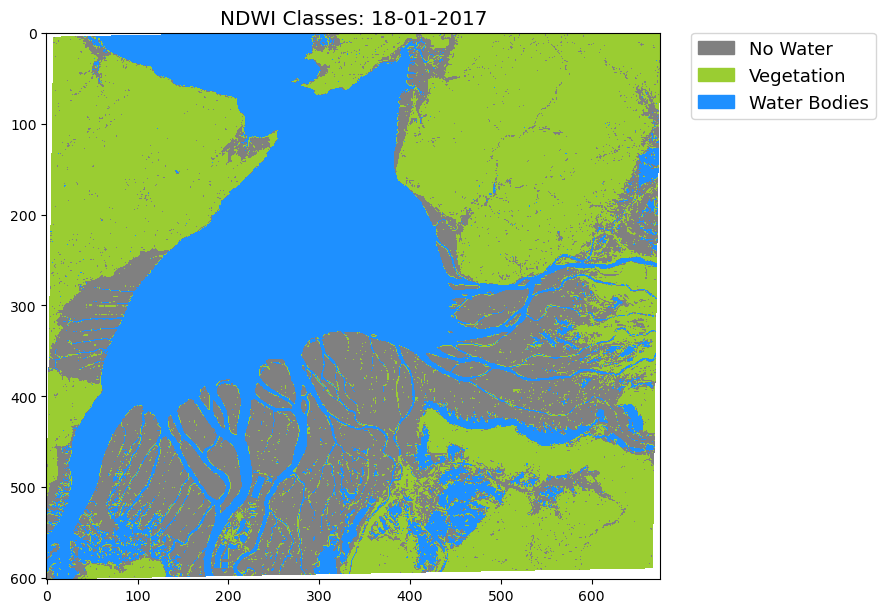

In [8]:
# plot categorized data
fig, ax = plt.subplots(figsize=(9, 9))
image = ax.imshow(ndwi_landsat_class, cmap=nbr_cmap)

ep.draw_legend(im_ax=image, classes=classes, titles=ndwi_cat_names)
ax.set_title('NDWI Classes: 18-01-2017', size='x-large')

plt.tight_layout()
plt.show()

We can mask the data into water and non water pixels by applying a threshold value - in this case for NDWI 0.6. Image masking is a technique used to separate or isolate specific areas of an image from the rest, allowing for more precise editing and manipulation. We need the mask to be binary (to contain zeros and ones).The mask will be the base product in detecting any changes.

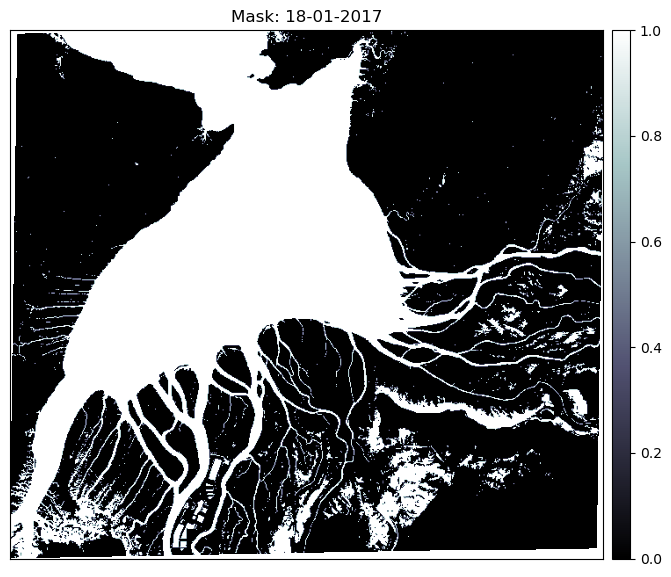

In [9]:
# mask the data into water and non water pixels
threshold = 0.6
mask_before = (ndwi_before > threshold).astype(int)

# plot mask; white pixels indicate water
ep.plot_bands(mask_before, cmap='bone', figsize=(8, 8), title='Mask: 18-01-2017')
plt.show()

In [10]:
# find percentage of valid pixels in mask
count = np.count_nonzero(mask_before == 1.0)
total_pixels = mask_before.size

# alternatively
#count = np.count_nonzero(ndwi_before > 0.6)
#total_pixels = ndwi_before.size

print(f'Water pixels in mask: {count * 100 / total_pixels:.4}%')

Water pixels in mask: 34.36%


### 2. Loading and Viewing Imagery During Flooding

Now, we will repeat the same steps to generate the mask from an image captured during flooding in January 2020 for the same exact region.

In [11]:
# extract TIFF files and stack into one array
img_after_path = glob(
    'madagascar_after/2020-01-27-00_00_2020-01-27-23_59_Landsat_8_*B*.tiff'
)
img_after_path.sort()
arr_after, meta = es.stack(img_after_path, nodata=-9999)

print('Image shape:', arr_after.shape)

Image shape: (9, 602, 676)


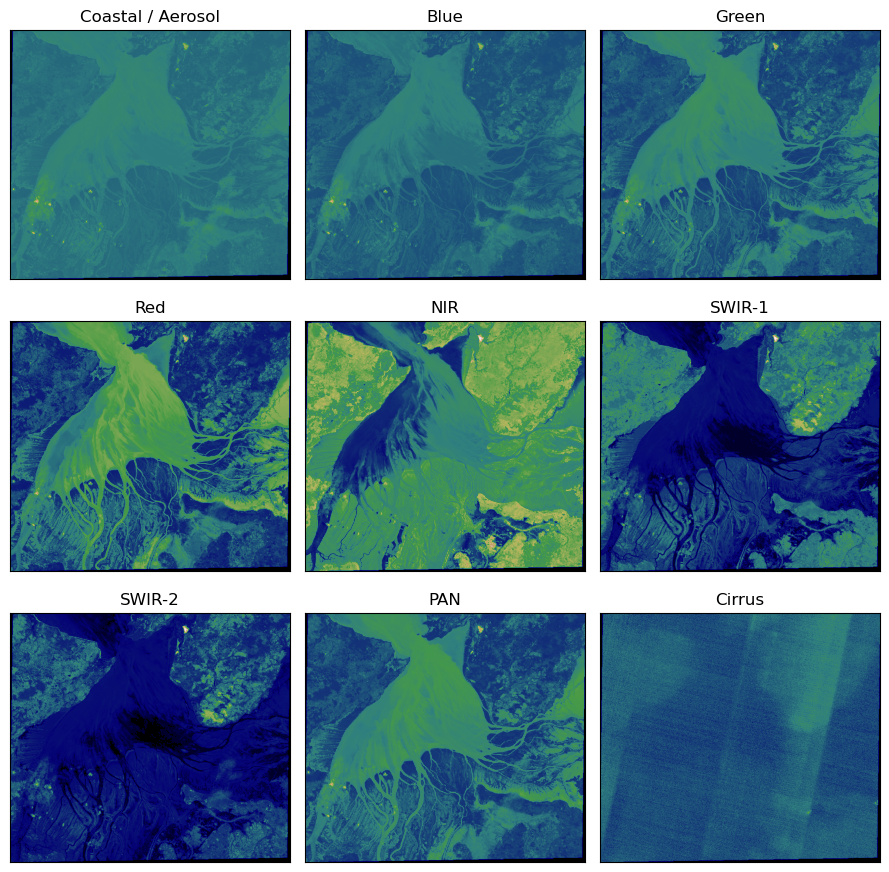

In [12]:
# plot each band
titles = [
    'Coastal / Aerosol', 'Blue', 'Green', 'Red', 'NIR',
    'SWIR-1', 'SWIR-2', 'PAN', 'Cirrus'
]

ep.plot_bands(arr_after, cmap='gist_earth', cols=3, cbar=False, title=titles, figsize=(9, 9))
plt.show()

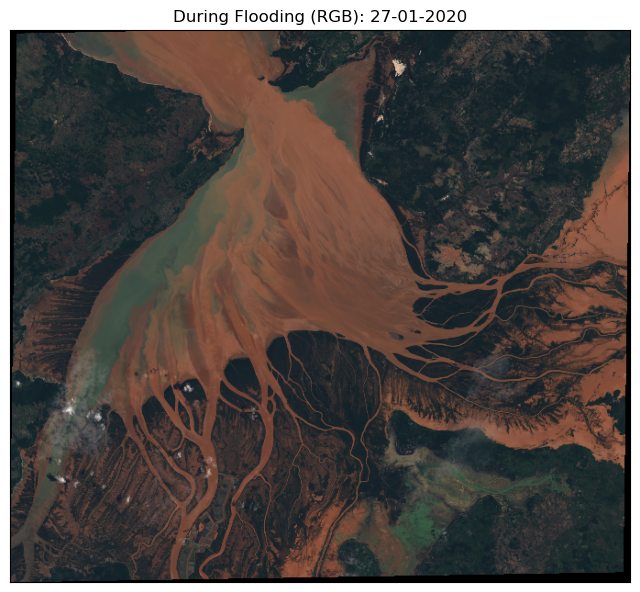

In [13]:
# plot true color composite (red, green, blue)
ep.plot_rgb(arr_after, rgb=(3, 2, 1), figsize=(8, 8), title='During Flooding (RGB): 27-01-2020')
plt.show()

This image reveals the extent of inundation. Without any data preprocessing, we can clearly spot water contamination and pollution resulting from floodwaters. The image exposes the dramatic landscape change.

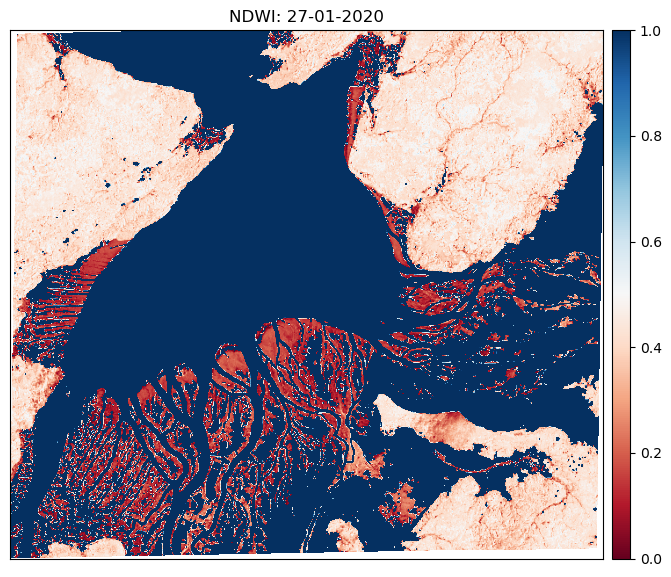

In [14]:
# calculate and plot new NDWI
ndwi_after = es.normalized_diff(arr_after[5], arr_after[7])

ep.plot_bands(ndwi_after, cmap='RdBu', vmin=0, vmax=1, figsize=(8, 8), title='NDWI: 27-01-2020')
plt.show()

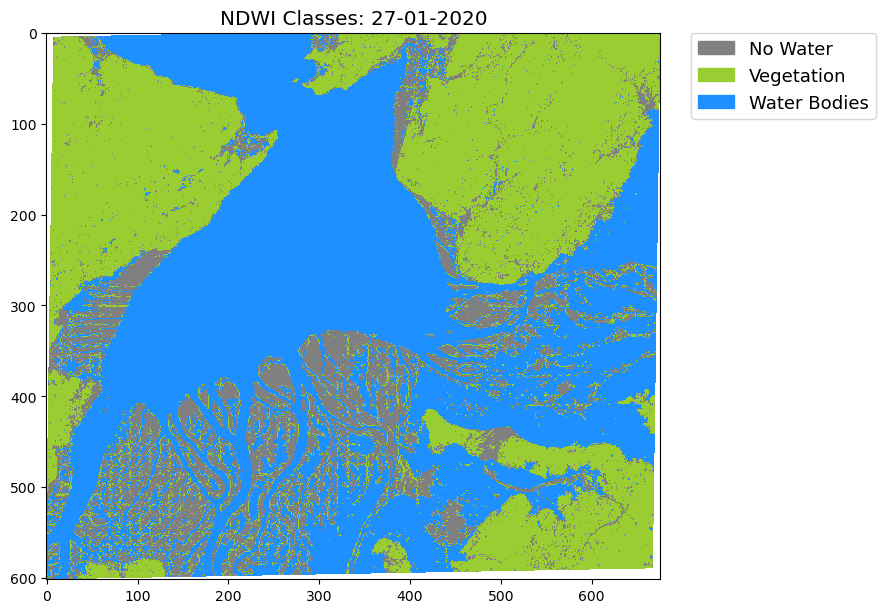

In [15]:
# create new classes and apply to NDWI results
ndwi_landsat_class = np.digitize(ndwi_after, ndwi_class_bins)

# apply the no-data mask to the newly classified NDWI data
ndwi_landsat_class = np.ma.masked_where(
    np.ma.getmask(ndwi_after), ndwi_landsat_class
)

# plot categorized data
fig, ax = plt.subplots(figsize=(9, 9))
image = ax.imshow(ndwi_landsat_class, cmap=nbr_cmap)

ep.draw_legend(im_ax=image, classes=classes, titles=ndwi_cat_names)
ax.set_title('NDWI Classes: 27-01-2020', size='x-large')

plt.tight_layout()
plt.show()

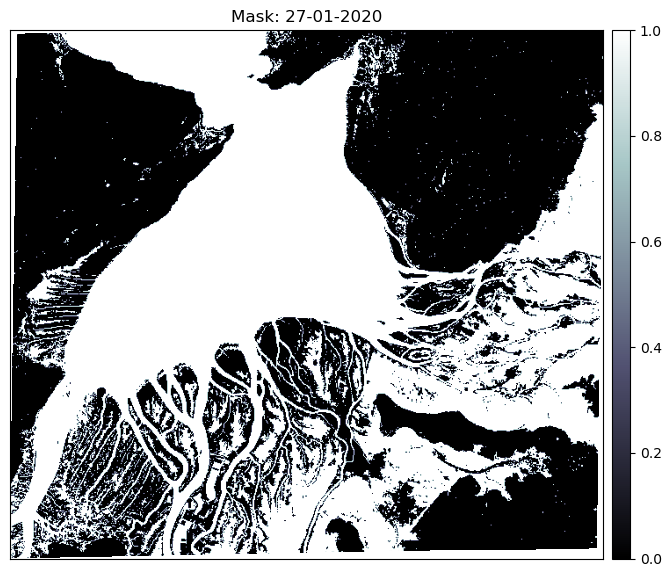

In [16]:
# mask the data into water and non water pixels
mask_after = (ndwi_after > threshold).astype(int)

# plot mask
ep.plot_bands(mask_after, cmap='bone', figsize=(8, 8), title='Mask: 27-01-2020')
plt.show()

In [17]:
# find percentage of water pixels
count = np.count_nonzero(mask_after == 1.0)
total_pixels = mask_after.size

print(f'Water pixels in mask: {count * 100 / total_pixels:.4}%')

Water pixels in mask: 48.63%


Almost half of the raster contains detected water pixels. The change is significant.

### 3. Calculate Change and Map Flooding

Let's take a look at the difference in NDWI between the scene in January 2017 and January 2020. We can compute the difference in NDWI between two dates. For a much better view, we will overlay this difference on the imagery.

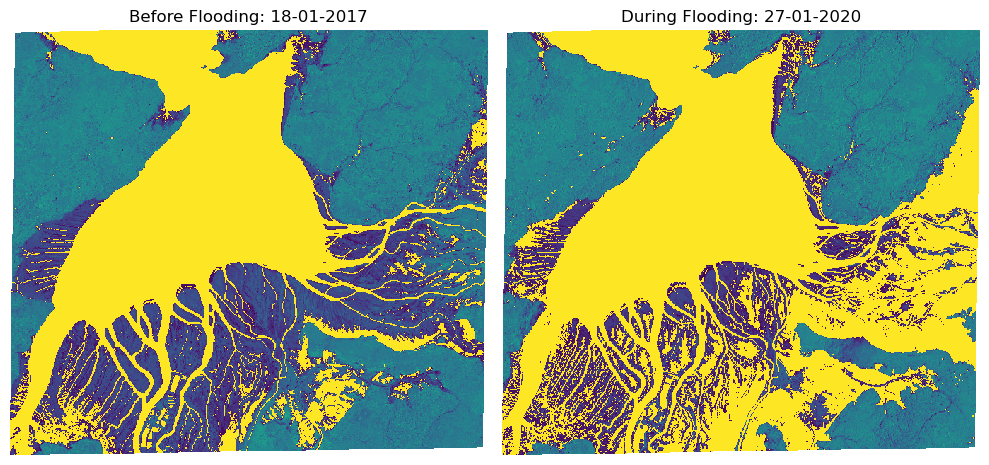

In [18]:
# compare rasters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# 1. before flooding
ax1.imshow(ndwi_before, vmin=0, vmax=1, interpolation='none')
ax1.set_title('Before Flooding: 18-01-2017')
ax1.set_axis_off()

# 2. during flooding
ax2.imshow(ndwi_after, vmin=0, vmax=1, interpolation='none')
ax2.set_title('During Flooding: 27-01-2020')
ax2.set_axis_off()

plt.tight_layout()
plt.show()

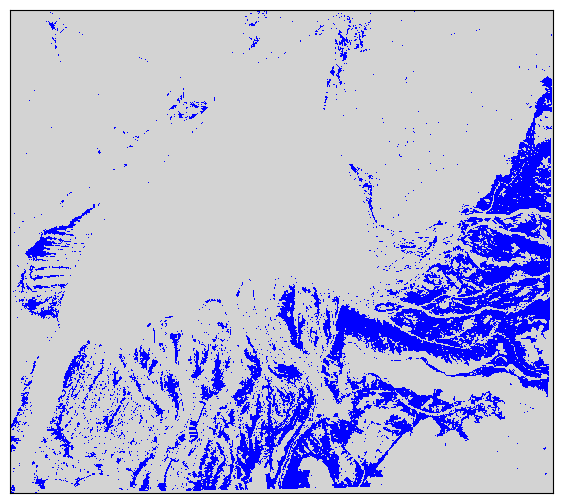

In [19]:
# find the difference and visualize it
mask_diff = (mask_after - mask_before)
mask_diff = np.where(mask_diff < 0, 0, mask_diff)

# blue pixels represent the difference
ep.plot_bands(mask_diff, cmap=ListedColormap(['lightgray', 'blue']), cbar=False, figsize=(7, 7))
plt.show()

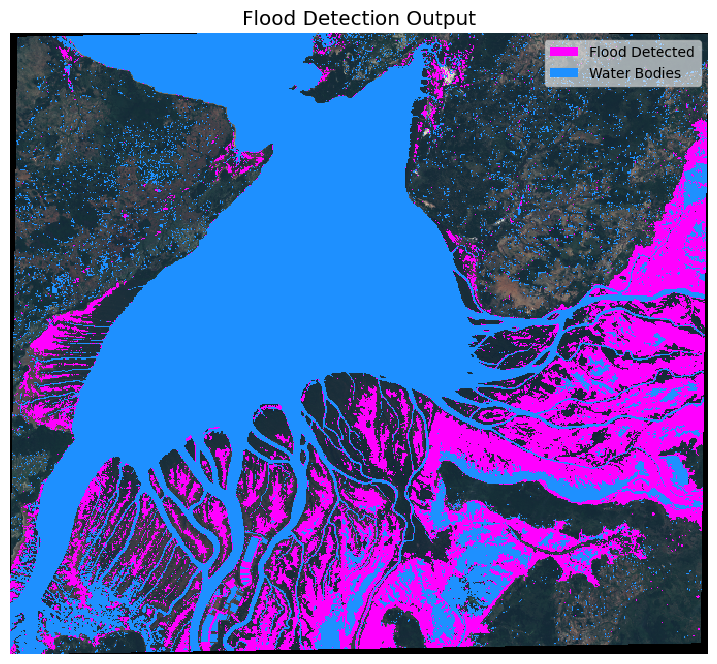

In [20]:
from matplotlib.patches import Rectangle

def normalize_band(band):
    return (band - band.min()) / (band.max() - band.min())

# prepare base image for plotting
image = np.dstack((
    normalize_band(arr_before[3]),
    normalize_band(arr_before[2]),
    normalize_band(arr_before[1]),
))

# color maps; #ffffff00 is transparant
flood_cmap = ListedColormap(['#ffffff00', 'magenta'])
water_cmap = ListedColormap(['#ffffff00', 'dodgerblue'])

# patches for the legend
flood_patch = Rectangle((0, 0), 1, 1, fc='magenta', edgecolor='none')
water_patch = Rectangle((0, 0), 1, 1, fc='dodgerblue', edgecolor='none')

# overlay image and masks
fig = plt.figure(figsize=(9, 9))

plt.imshow(image, interpolation='none')
plt.imshow(ndwi_before, vmin=0, vmax=1, cmap=water_cmap, interpolation='none')
plt.imshow(mask_diff, vmin=0, vmax=1, cmap=flood_cmap, interpolation='none')
plt.title('Flood Detection Output', size='x-large')

plt.legend(
    handles=[flood_patch, water_patch],
    labels=['Flood Detected', 'Water Bodies'],
    loc='upper right',
    framealpha=0.6,
)

plt.axis('off')
plt.show()

### 4. Conclusions

This project presents a review of flood detection using Landsat 8 imagery. Our detection approach included thresholding and image masking. Water pixels were recognized on the satellite image based on its band combination and remote sensing index. By comparing two masks, we are able to separate flooding from actual water bodies - in this case the bay and its river flows. The flooded areas constitute approximately 14.27% of the entire raster. This easy approach can be useful in urban flood mapping, particularly with regard to handling the flood risk in transportation facilities or to determine which regions need urgent evacuation.

**References:**

* https://earthpy.readthedocs.io/en/latest/gallery_vignettes/plot_calculate_classify_ndvi.html
* https://en.wikipedia.org/wiki/Bombetoka_Bay
* https://geoawesome.com/eo-hub/how-satellite-data-is-used-to-monitor-flooding-from-space/
* https://geohackweek.github.io/raster/04-workingwithrasters/